# **Capstone Project - Dashboard UMKM Kembar Barokah**

Colab ini bertujuan untuk membangun model LSTM Forecasting untuk memprediksi penjualan dan pendapatan produk tiap minggunya.

## **Preparation Tools**

In [1]:
# Import library yang dibutuhkan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import joblib
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from pandas.tseries.offsets import DateOffset

In [2]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

## **Data Preparation**

In [3]:
# Load dataset audit umkm
df = pd.read_csv('/content/Susunan Data Audit UMKM Kembar Barokah - Ready for Model - Capstone Project (Final).csv')
df

,Tanggal_Audit (dd-mm-yy),Nama_Produk,Bulan,Minggu_ke,is_minggu_gajian,is_libur_nasional,Jumlah_Produk_Terjual
0,06-01-25,Kerupuk Kulit,1,2,1,1,1450
1,06-01-25,Keripik Bawang,1,2,1,1,1577
2,06-01-25,Stik Bawang,1,2,1,1,1633
3,13-01-25,Kerupuk Kulit,1,3,0,0,1275
4,13-01-25,Keripik Bawang,1,3,0,0,7280
...,...,...,...,...,...,...,...
127,27-10-25,Keripik Bawang,10,44,1,0,4026
128,27-10-25,Stik Bawang,10,44,1,0,1006
129,03-11-25,Kerupuk Kulit,11,45,1,0,725
130,03-11-25,Keripik Bawang,11,45,1,0,1070


In [4]:
# Cek informasi dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Tanggal_Audit (dd-mm-yy)  132 non-null    object
 1   Nama_Produk               132 non-null    object
 2   Bulan                     132 non-null    int64 
 3   Minggu_ke                 132 non-null    int64 
 4   is_minggu_gajian          132 non-null    int64 
 5   is_libur_nasional         132 non-null    int64 
 6   Jumlah_Produk_Terjual     132 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 7.3+ KB


In [5]:
# Buat salinan untuk di-clean
df_clean = df.copy()

In [6]:
# Ubah nama kolom "Tanggal_Audit (dd-mm-yy)" menjadi "Tanggal_Audit"
df_clean.rename(columns={'Tanggal_Audit (dd-mm-yy)': 'Tanggal_Audit'}, inplace=True)
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   Tanggal_Audit          132 non-null    object
 1   Nama_Produk            132 non-null    object
 2   Bulan                  132 non-null    int64 
 3   Minggu_ke              132 non-null    int64 
 4   is_minggu_gajian       132 non-null    int64 
 5   is_libur_nasional      132 non-null    int64 
 6   Jumlah_Produk_Terjual  132 non-null    int64 
dtypes: int64(5), object(2)
memory usage: 7.3+ KB


In [7]:
# Buat salinan untuk inkonsistensi
df_clean_inconsistent = df_clean.copy()

In [8]:
# Cleaning format data yang inkonsisten
df_clean_inconsistent['Tanggal_Audit'] = pd.to_datetime(df_clean_inconsistent['Tanggal_Audit'], format='%d-%m-%y')
df_clean_inconsistent = df_clean_inconsistent.sort_values(by=['Nama_Produk', 'Tanggal_Audit'])

In [9]:
# Membuat fitur terbaru 'Jumlah_Terjual_Minggu_Lalu'
df_clean_inconsistent['Jumlah_Terjual_Minggu_Lalu'] = df_clean_inconsistent.groupby('Nama_Produk')['Jumlah_Produk_Terjual'].shift(1)
df_clean_inconsistent

,Tanggal_Audit,Nama_Produk,Bulan,Minggu_ke,is_minggu_gajian,is_libur_nasional,Jumlah_Produk_Terjual,Jumlah_Terjual_Minggu_Lalu
1,2025-01-06,Keripik Bawang,1,2,1,1,1577,NaN
4,2025-01-13,Keripik Bawang,1,3,0,0,7280,1577.0
7,2025-01-20,Keripik Bawang,1,4,0,0,4057,7280.0
10,2025-01-27,Keripik Bawang,1,5,1,0,3948,4057.0
13,2025-02-03,Keripik Bawang,2,6,1,1,4862,3948.0
...,...,...,...,...,...,...,...,...
119,2025-10-06,Stik Bawang,10,41,0,0,1215,1011.0
122,2025-10-13,Stik Bawang,10,42,0,0,1011,1215.0
125,2025-10-20,Stik Bawang,10,43,0,0,990,1011.0
128,2025-10-27,Stik Bawang,10,44,1,0,1006,990.0


In [10]:
# Pilih kolom yang relevan dengan proyek
df_clean_inconsistent = df_clean_inconsistent.loc[:, ['Nama_Produk', 'Tanggal_Audit', 'Jumlah_Produk_Terjual', 'Jumlah_Terjual_Minggu_Lalu', 'is_minggu_gajian', 'is_libur_nasional']]

# Hapus baris yang ada Null Values
df_clean_inconsistent = df_clean_inconsistent.dropna()
df_clean_inconsistent

,Nama_Produk,Tanggal_Audit,Jumlah_Produk_Terjual,Jumlah_Terjual_Minggu_Lalu,is_minggu_gajian,is_libur_nasional
4,Keripik Bawang,2025-01-13,7280,1577.0,0,0
7,Keripik Bawang,2025-01-20,4057,7280.0,0,0
10,Keripik Bawang,2025-01-27,3948,4057.0,1,0
13,Keripik Bawang,2025-02-03,4862,3948.0,1,1
16,Keripik Bawang,2025-02-10,8815,4862.0,0,0
...,...,...,...,...,...,...
119,Stik Bawang,2025-10-06,1215,1011.0,0,0
122,Stik Bawang,2025-10-13,1011,1215.0,0,0
125,Stik Bawang,2025-10-20,990,1011.0,0,0
128,Stik Bawang,2025-10-27,1006,990.0,1,0


In [11]:
# Cek data setelah di-clean
df_clean_inconsistent.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129 entries, 4 to 131
Data columns (total 6 columns):
 #   Column                      Non-Null Count  Dtype         
---  ------                      --------------  -----         
 0   Nama_Produk                 129 non-null    object        
 1   Tanggal_Audit               129 non-null    datetime64[ns]
 2   Jumlah_Produk_Terjual       129 non-null    int64         
 3   Jumlah_Terjual_Minggu_Lalu  129 non-null    float64       
 4   is_minggu_gajian            129 non-null    int64         
 5   is_libur_nasional           129 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 7.1+ KB


In [12]:
# Preview data setelah di-clean
df_clean_inconsistent

,Nama_Produk,Tanggal_Audit,Jumlah_Produk_Terjual,Jumlah_Terjual_Minggu_Lalu,is_minggu_gajian,is_libur_nasional
4,Keripik Bawang,2025-01-13,7280,1577.0,0,0
7,Keripik Bawang,2025-01-20,4057,7280.0,0,0
10,Keripik Bawang,2025-01-27,3948,4057.0,1,0
13,Keripik Bawang,2025-02-03,4862,3948.0,1,1
16,Keripik Bawang,2025-02-10,8815,4862.0,0,0
...,...,...,...,...,...,...
119,Stik Bawang,2025-10-06,1215,1011.0,0,0
122,Stik Bawang,2025-10-13,1011,1215.0,0,0
125,Stik Bawang,2025-10-20,990,1011.0,0,0
128,Stik Bawang,2025-10-27,1006,990.0,1,0


In [13]:
# Simpan salinan clean ke df_final
df_final = df_clean_inconsistent.copy()

In [14]:
# Load data libur nasional
holiday_csv_path_df = pd.read_csv('/content/Tanggal Libur Nasional 2025.csv')
holiday_csv_path_df

,Tanggal,Hari,Keterangan,Minggu Audit Terdampak (Tanggal_Audit Senin berikutnya)
0,1 January,Rabu,Tahun Baru 2025 Masehi,6 January 2025
1,27 January,Senin,Isra Mi'raj Nabi Muhammad SAW,3 February 2025
2,28 January,Selasa,Cuti Bersama Tahun Baru Imlek,3 February 2025
3,29 January,Rabu,Tahun Baru Imlek 2576 Kongzili,3 February 2025
4,28 March,Jumat,Cuti Bersama Hari Suci Nyepi,31 March 2025
5,29 March,Sabtu,Hari Suci Nyepi 1947,31 March 2025
6,31 March,Senin,Idul Fitri 1446 H,7 April 2025
7,1 April,Selasa,Idul Fitri 1446 H,7 April 2025
8,2 April,Rabu,Cuti Bersama Idul Fitri,7 April 2025
9,3 April,Kamis,Cuti Bersama Idul Fitri,7 April 2025


## **Modeling**

In [15]:
# Tampilkan daftar produk yang tersedia
produk_list = df_final['Nama_Produk'].unique()
print('Produk yang tersedia:', produk_list)

Produk yang tersedia: ['Keripik Bawang' 'Kerupuk Kulit' 'Stik Bawang']


In [16]:
# Load dataset daftar hari libur nasional
def load_holidays(holiday_csv_path):
    print(f"Memuat data hari libur dari: {holiday_csv_path}")

    try:
        df_holidays = pd.read_csv(holiday_csv_path)
    except FileNotFoundError:
        print(f"Error: File tidak ditemukan di path: {holiday_csv_path}")
        return None

    # Nama kolom yang berisi tanggal (sesuai hasil inspeksi)
    date_column_name = 'Tanggal'

    if date_column_name not in df_holidays.columns:
        print(f"Error: Kolom '{date_column_name}' tidak ditemukan di file CSV hari libur.")
        print("Silakan pastikan nama kolom tanggal sudah benar.")
        return None

    try:
        # 1. Ambil kolom 'Tanggal' (misal: "1 January")
        # 2. Tambahkan string " 2025" (menjadi: "1 January 2025")
        # 3. Konversi menggunakan format '%d %B %Y'

        df_holidays['Tanggal_Penuh'] = df_holidays[date_column_name] + ' 2025'

        df_holidays['Tanggal_Datetime'] = pd.to_datetime(
            df_holidays['Tanggal_Penuh'],
            format='%d %B %Y'
        )

    except ValueError as e:
        print(f"Error saat mengonversi tanggal: {e}")
        print("Pastikan format di CSV konsisten (misal: '1 January', '27 January', dll.)")
        return None

    # Buat satu set (HashSet) dari tanggal libur untuk pencarian cepat (O(1))
    holiday_set = set(df_holidays['Tanggal_Datetime'].dt.normalize())

    print("Data hari libur berhasil dimuat dan diproses.")
    return holiday_set

In [17]:
# Fungsi pembuat sequence untuk time series
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # kolom jumlah_penjualan
    return np.array(X), np.array(y)

In [18]:
# Model lstm untuk forecasting
def build_model(input_shape):
    model = Sequential([
        LSTM(32, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        # Dense(64, activation='relu'),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [19]:
# Plot hasil akurasi dan loss pelatihan model lstm
def plot_training_history(history, product_name):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Riwayat Training (Loss vs Validation Loss) - {product_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.legend()
    # plt.savefig(f'history_{product_name.replace(" ", "_")}.png')
    plt.show()

In [20]:
# Plot hasil prediksi dengan data aktual
def plot_predictions(dates, y_test_inv, pred_inv, product_name):
    plt.figure(figsize=(10, 5))
    ax = plt.gca() # Get Current Axes
    ax.plot(dates, y_test_inv, label='Actual', marker='o', markersize=4)
    ax.plot(dates, pred_inv, label='Predicted', linestyle='--')
    # Format tanggal untuk label X
    date_formatter = mdates.DateFormatter('%y-%m-%d')
    ax.xaxis.set_major_formatter(date_formatter)
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')
    plt.title(f'Prediksi Penjualan Mingguan (Test Set) - {product_name}')
    plt.xlabel('Tanggal Audit (yy-mm-dd)')
    plt.ylabel('Jumlah Penjualan')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f'prediksi_{product_name.replace(" ", "_")}.png')
    plt.show()

In [21]:
# Fungsi untuk inverse transform terhadap data yang telah di-scaling
def inverse_transform_helper(scaled_values, scaler, n_features, target_index=0):
    scaled_values = np.array(scaled_values).flatten()
    # Buat array dummy seukuran jumlah fitur
    dummy = np.zeros((len(scaled_values), n_features))
    # Isi kolom pertama (target) dengan nilai
    dummy[:, target_index] = scaled_values
    # Invers transform
    inv = scaler.inverse_transform(dummy)[:, target_index]
    return inv

In [22]:
# Fungsi untuk fitur kalender masa depan
def get_future_calendar_features(date_range, holiday_set):
    features = []
    for date in date_range:
        start_week = (date - DateOffset(days=6)).normalize()
        end_week = date.normalize()
        week_range = pd.date_range(start_week, end_week)

        # Logika minggu gajian (Tgl 25 - 3)
        is_gajian = any(d.day >= 25 or d.day <= 3 for d in week_range)

        # Logika libur nasional (Menggunakan data dari CSV)
        is_libur = any(d in holiday_set for d in week_range)

        features.append({
            'Tanggal_Audit': date,
            'is_minggu_gajian': 1 if is_gajian else 0,
            'is_libur_nasional': 1 if is_libur else 0
        })
    return pd.DataFrame(features)

In [23]:
# Fungsi rekursif untuk prediksi masa depan
def generate_multistep_forecast(model, scaler, all_product_data, future_features, window_size, n_features):
    print("Membuat prediksi multi-step")
    forecast_scaled = []
    current_window = all_product_data[-window_size:].copy()

    for i in range(len(future_features)):
        # Prediksi
        pred_scaled = model.predict(np.expand_dims(current_window, axis=0))[0]
        forecast_scaled.append(pred_scaled[0])

        # Buat input baru untuk loop berikutnya
        new_row = np.array([
            pred_scaled[0],                 # Fitur 0: Jumlah_Produk_Terjual (yang baru diprediksi)
            current_window[-1, 0],          # Fitur 1: Jumlah_Terjual_Minggu_Lalu (target dari window sebelumnya)
            future_features[i, 0],          # Fitur 2: is_minggu_gajian
            future_features[i, 1]           # Fitur 3: is_libur_nasional
        ])

        # "Geser" window
        current_window = np.append(current_window[1:], [new_row], axis=0)

    forecast = inverse_transform_helper(np.array(forecast_scaled), scaler, n_features)
    return np.ceil(forecast)

In [24]:
# Plot data aktual dengan hasil prediksi dalam satu line chart
def plot_combined_forecast(product_name, historical_data, forecast_data, n_history=52):
    print(f"Membuat plot gabungan untuk {product_name}")

    hist_to_plot = historical_data.iloc[-n_history:]
    hist_dates = hist_to_plot['Tanggal_Audit']
    hist_values = hist_to_plot['Jumlah_Produk_Terjual']

    last_hist_date = hist_dates.iloc[-1]
    forecast_dates = pd.date_range(start=last_hist_date + DateOffset(weeks=1), periods=len(forecast_data), freq='W-MON')

    plt.figure(figsize=(12, 6))

    # Get Current Access untuk kustomisasi "axes" saat ini
    ax = plt.gca()
    ax.plot(hist_dates, hist_values, label='Data Historis Aktual', color='blue')
    ax.plot(forecast_dates, forecast_data, label='Prediksi Masa Depan (Forecast)', color='red', linestyle='--')

    # Sambungkan line chart
    connect_dates = [hist_dates.iloc[-1], forecast_dates[0]]
    connect_values = [hist_values.iloc[-1], forecast_data[0]]
    ax.plot(connect_dates, connect_values, color='red', linestyle='--')

    # Format yang disesuaikan
    date_formatter = mdates.DateFormatter('%y-%m-%d')
    # Terapkan format
    ax.xaxis.set_major_formatter(date_formatter)
    # Label dirotasi agar tidak overlap
    plt.setp(ax.get_xticklabels(), rotation=30, ha='right')

    plt.title(f'Forecast Penjualan Mingguan - {product_name}')
    plt.xlabel('Tanggal Audit (yy-mm-dd)')
    plt.ylabel('Jumlah Penjualan (pcs)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(f'forecast_gabungan_{product_name.replace(" ", "_")}.png')
    plt.show()

In [25]:
# Fungsi pelatihan dan prediksi untuk setiap produk
def train_and_evaluate_product(product_name, df, holiday_set, window_size, forecast_steps):
    print(f"\nMemulai Proses untuk: {product_name}")

    # Filter data dan siapkan fitur
    df_prod = df[df['Nama_Produk'] == product_name].copy()
    df_prod_features = df_prod[['Jumlah_Produk_Terjual', 'Jumlah_Terjual_Minggu_Lalu', 'is_minggu_gajian', 'is_libur_nasional']]
    n_features = df_prod_features.shape[1]

    historical_data_for_plot = df_prod[['Tanggal_Audit', 'Jumlah_Produk_Terjual']].copy()

    # Cek data
    if len(df_prod_features) < (window_size * 2):
        print(f"Data tidak cukup untuk melatih {product_name}. Dilewati.")
        return None

    # Normalisasi
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df_prod_features)

    # Ambil fitur eksternal
    df_features_only = df_prod_features[['is_minggu_gajian', 'is_libur_nasional']]

    # Normalisasi untuk fitur eksternal
    scaler_features_only = MinMaxScaler(feature_range=(0, 1))
    scaler_features_only.fit(df_features_only)

    # Buat sequence
    X, y = create_sequences(scaled_data, window_size)

    if len(X) < 5: # Butuh setidaknya 5 sequence untuk di-split
        print(f"Data sequence tidak cukup untuk di-split pada {product_name}. Dilewati.")
        return None

    df_prod_dates = df_prod['Tanggal_Audit'].iloc[window_size:]

    # Split train-test
    X_train, X_test, y_train, y_test, dates_train, dates_test = train_test_split(X, y, df_prod_dates, test_size=0.2, shuffle=False)

    if len(X_train) == 0 or len(X_test) == 0:
        print(f"Data tidak cukup untuk split train/test pada {product_name}")
        return None

    # Bangun model
    model = build_model(input_shape=(X_train.shape[1], X_train.shape[2]))

    # Latih model
    print(f"Melatih model {product_name}")
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        epochs=100,
        batch_size=8,
        validation_data=(X_test, y_test),
        callbacks=[early_stop],
        verbose=1  # Set ke 1 jika ingin lihat proses epoch
    )

    # Plot riwayat training (Loss vs Val_Loss)
    plot_training_history(history, product_name)

    # Prediksi di Test Set
    predicted_scaled = model.predict(X_test)

    # Invers normalisasi hasil
    y_test_inv = inverse_transform_helper(y_test, scaler, n_features)
    pred_inv = inverse_transform_helper(predicted_scaled, scaler, n_features)

    # Plot hasil prediksi (Aktual vs Prediksi)
    plot_predictions(dates_test, y_test_inv, pred_inv, product_name)

    # Forecast minggu depan
    print(f"Mempersiapkan data masa depan untuk {product_name}...")

    # Buat data kalender masa depan
    last_hist_date = historical_data_for_plot['Tanggal_Audit'].iloc[-1]
    future_dates = pd.date_range(start=last_hist_date + DateOffset(weeks=1), periods=forecast_steps, freq='W-MON')

    # Gunakan holiday_set yang sudah dimuat
    df_future_features_raw = get_future_calendar_features(future_dates, holiday_set)

    # Scale fitur masa depan
    future_features_scaled = scaler_features_only.transform(df_future_features_raw[['is_minggu_gajian', 'is_libur_nasional']])

    # Generate prediksi multi-step
    forecast_values = generate_multistep_forecast(
        model, scaler, scaled_data,
        future_features_scaled, window_size, n_features
    )

    # Plot gabungan
    plot_combined_forecast(
        product_name, historical_data_for_plot, forecast_values
    )

    # Simpan model lstm keras
    model_path = f"models/model_{product_name.replace(' ', '_')}.h5"
    model.save(model_path)

    # Simpan min max scaler
    scaler_path = f"models/scaler_{product_name.replace(' ', '_')}.save"
    joblib.dump(scaler, scaler_path) # 'scaler' adalah variabel scaler

    # Simpan min max scaler fitur eksternal
    scaler_features_path = f"models/scaler_features_{product_name.replace(' ', '_')}.save"
    joblib.dump(scaler_features_only, scaler_features_path)

    print(f"Prediksi {forecast_steps} minggu ke depan untuk {product_name}: {forecast_values}\n")

    return {
        "produk": product_name,
        "prediksi_minggu_depan": forecast_values[0],
        "forecast_lengkap": forecast_values
    }

In [26]:
# Preprocessing data libur nasional
holiday_csv_path = '/content/Tanggal Libur Nasional 2025.csv'
holiday_set = load_holidays(holiday_csv_path)
holiday_set

Memuat data hari libur dari: /content/Tanggal Libur Nasional 2025.csv
Data hari libur berhasil dimuat dan diproses.


{Timestamp('2025-01-01 00:00:00'),
 Timestamp('2025-01-27 00:00:00'),
 Timestamp('2025-01-28 00:00:00'),
 Timestamp('2025-01-29 00:00:00'),
 Timestamp('2025-03-28 00:00:00'),
 Timestamp('2025-03-29 00:00:00'),
 Timestamp('2025-03-31 00:00:00'),
 Timestamp('2025-04-01 00:00:00'),
 Timestamp('2025-04-02 00:00:00'),
 Timestamp('2025-04-03 00:00:00'),
 Timestamp('2025-04-04 00:00:00'),
 Timestamp('2025-04-07 00:00:00'),
 Timestamp('2025-04-18 00:00:00'),
 Timestamp('2025-05-01 00:00:00'),
 Timestamp('2025-05-12 00:00:00'),
 Timestamp('2025-05-13 00:00:00'),
 Timestamp('2025-05-29 00:00:00'),
 Timestamp('2025-05-30 00:00:00'),
 Timestamp('2025-06-01 00:00:00'),
 Timestamp('2025-06-06 00:00:00'),
 Timestamp('2025-06-09 00:00:00'),
 Timestamp('2025-06-27 00:00:00'),
 Timestamp('2025-08-17 00:00:00'),
 Timestamp('2025-09-05 00:00:00'),
 Timestamp('2025-12-25 00:00:00'),
 Timestamp('2025-12-26 00:00:00')}


Memulai Proses untuk: Keripik Bawang
Melatih model Keripik Bawang
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.0665 - val_loss: 0.0084
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0403 - val_loss: 0.0038
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0430 - val_loss: 0.0041
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0376 - val_loss: 0.0059
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0350 - val_loss: 0.0059
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0304 - val_loss: 0.0054
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0360 - val_loss: 0.0053
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0410 - val_loss: 0.0053
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0401 - val_loss: 0.0049
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.0432 - val_loss: 0.0046
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0299 - val_loss: 0.0046
Epoch 

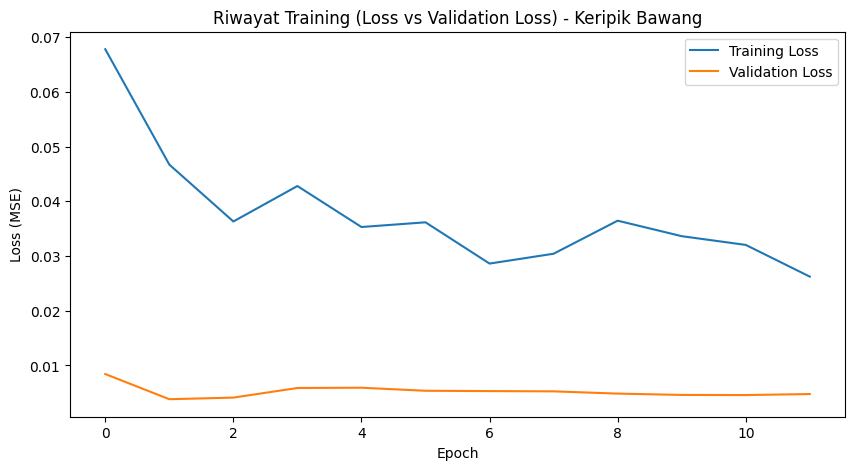

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step


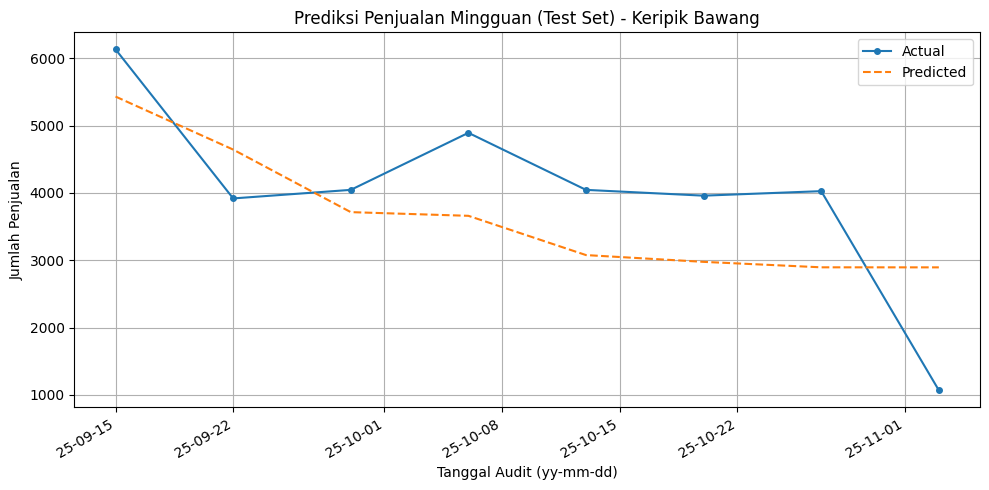

Mempersiapkan data masa depan untuk Keripik Bawang...
Membuat prediksi multi-step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
Membuat plot gabungan untuk Keripik Bawang


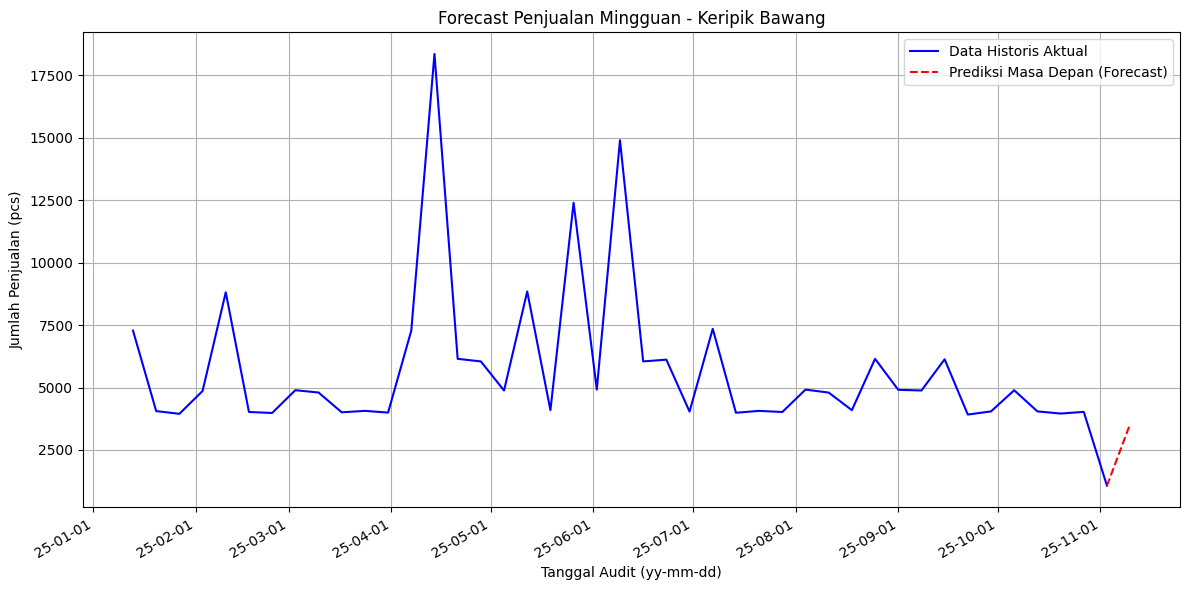

Prediksi 1 minggu ke depan untuk Keripik Bawang: [3541.]


Memulai Proses untuk: Kerupuk Kulit
Melatih model Kerupuk Kulit
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step - loss: 0.1569 - val_loss: 0.0036
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0479 - val_loss: 0.0025
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0829 - val_loss: 0.0036
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0977 - val_loss: 0.0065
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0696 - val_loss: 0.0094
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0655 - val_loss: 0.0115
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0419 - val_loss: 0.0125
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0487 - val_loss: 0.0122
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0610 - val_loss: 0.0114
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0710 - val_loss: 0.0099
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━

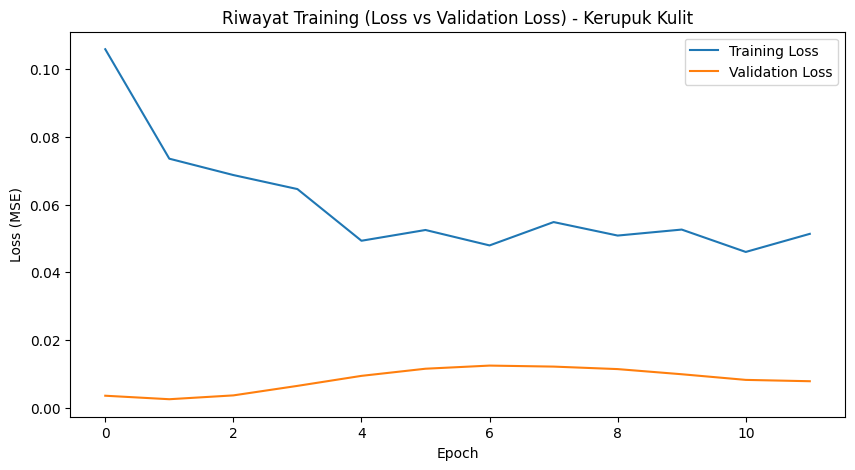

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step


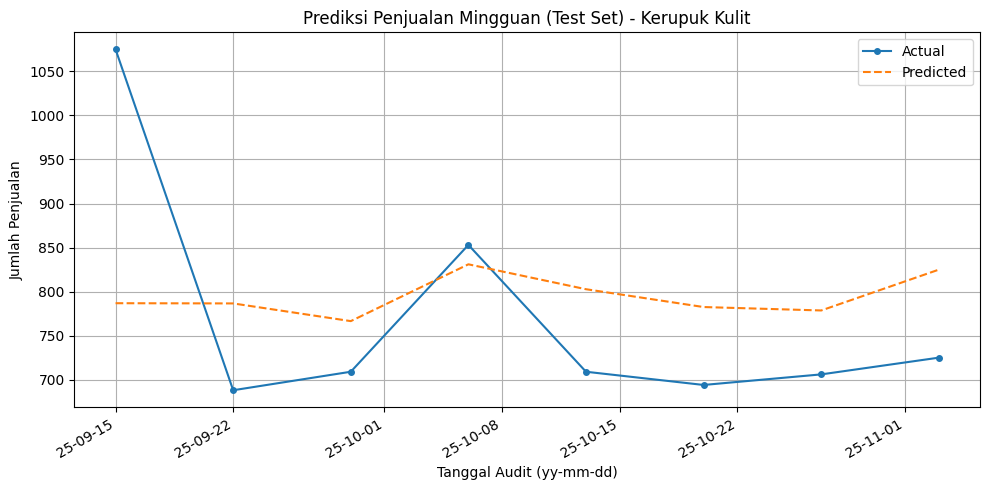

Mempersiapkan data masa depan untuk Kerupuk Kulit...
Membuat prediksi multi-step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
Membuat plot gabungan untuk Kerupuk Kulit


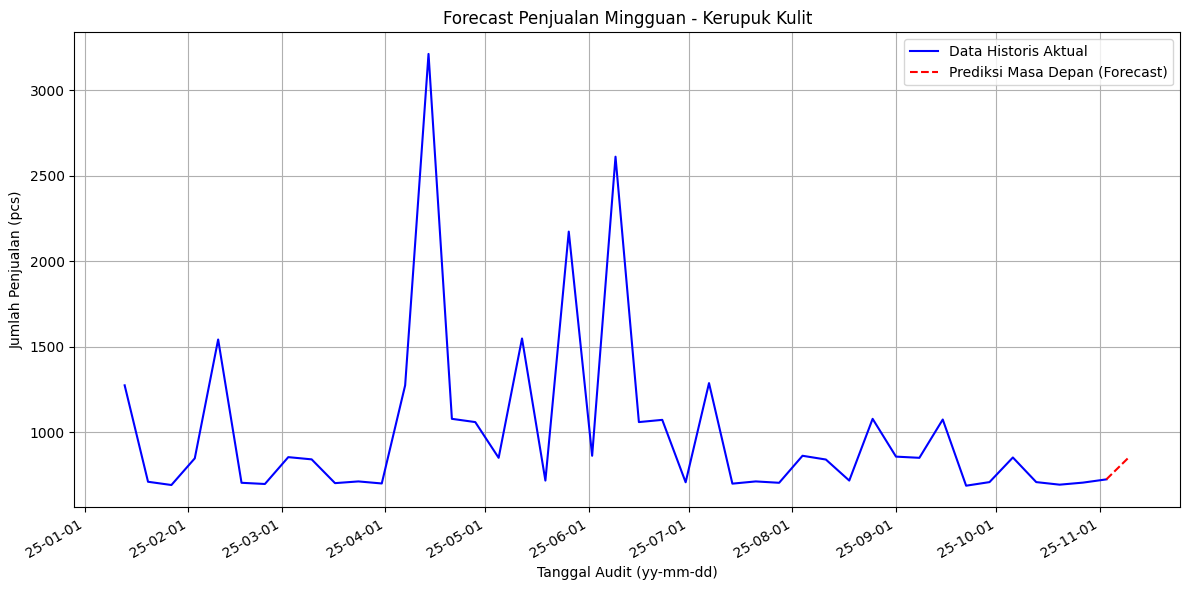

Prediksi 1 minggu ke depan untuk Kerupuk Kulit: [859.]


Memulai Proses untuk: Stik Bawang
Melatih model Stik Bawang
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - loss: 0.0623 - val_loss: 0.0012
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0535 - val_loss: 0.0021
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0430 - val_loss: 0.0042
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0295 - val_loss: 0.0066
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0275 - val_loss: 0.0087
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0548 - val_loss: 0.0101
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0444 - val_loss: 0.0098
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0572 - val_loss: 0.0096
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0343 - val_loss: 0.0081
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0381 - val_loss: 0.0066
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

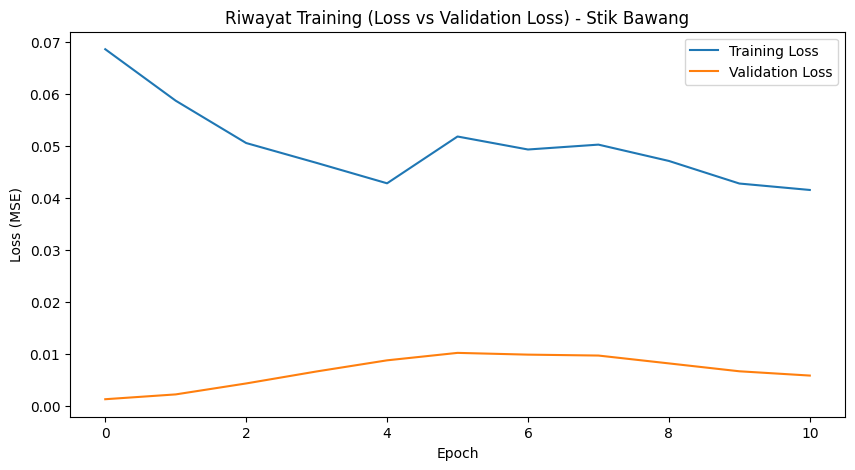

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


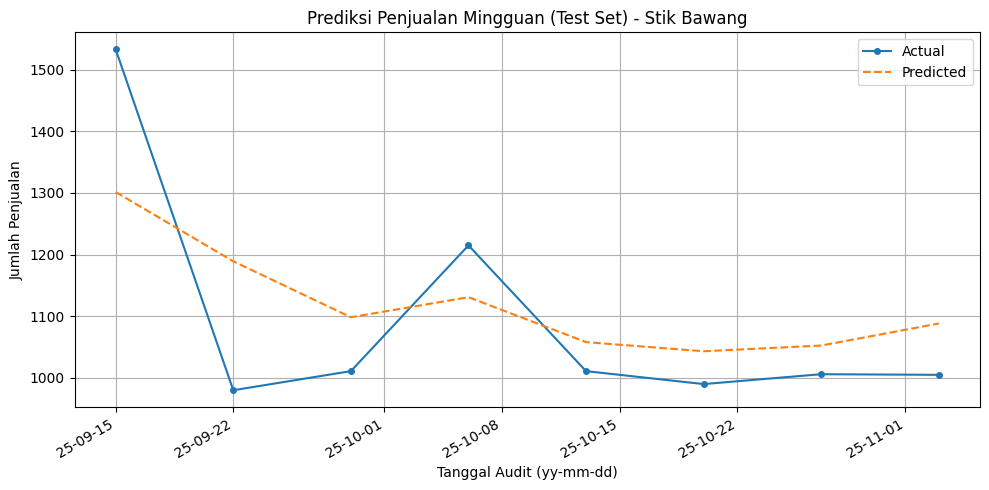

Mempersiapkan data masa depan untuk Stik Bawang...
Membuat prediksi multi-step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
Membuat plot gabungan untuk Stik Bawang


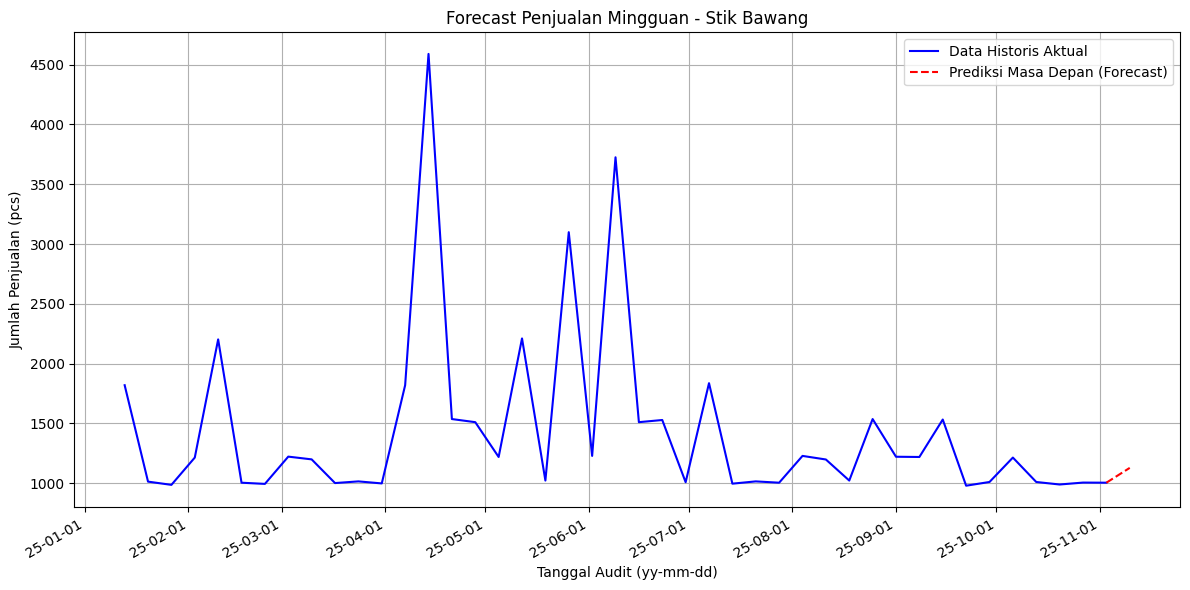

Prediksi 1 minggu ke depan untuk Stik Bawang: [1129.]



In [27]:
# Latih model untuk semua produk
hasil_prediksi = []
for p in produk_list:
    hasil = train_and_evaluate_product(p, df_final, holiday_set, window_size=4, forecast_steps=1)
    if hasil:
      hasil_prediksi.append(hasil)

In [28]:
# Tampilkan hasil akhir
df_prediksi = pd.DataFrame(hasil_prediksi)[['produk', 'prediksi_minggu_depan']]
print("\nHasil Prediksi Minggu Depan per Produk:")
print(df_prediksi)


Hasil Prediksi Minggu Depan per Produk:
           produk  prediksi_minggu_depan
0  Keripik Bawang                 3541.0
1   Kerupuk Kulit                  859.0
2     Stik Bawang                 1129.0


## **Saved Model & Scaler**

In [29]:
# Buat folder untuk menyimpan model dan scaler
os.makedirs('models', exist_ok=True)

In [30]:
# Simpan folder "models" ke dalam bentuk zip
!zip -r models.zip models

  adding: models/ (stored 0%)
  adding: models/model_Keripik_Bawang.h5 (deflated 29%)
  adding: models/scaler_Stik_Bawang.save (deflated 49%)
  adding: models/model_Stik_Bawang.h5 (deflated 32%)
  adding: models/model_Kerupuk_Kulit.h5 (deflated 32%)
  adding: models/scaler_features_Kerupuk_Kulit.save (deflated 51%)
  adding: models/scaler_Keripik_Bawang.save (deflated 47%)
  adding: models/scaler_features_Keripik_Bawang.save (deflated 51%)
  adding: models/scaler_Kerupuk_Kulit.save (deflated 49%)
  adding: models/scaler_features_Stik_Bawang.save (deflated 51%)
